In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv("data/[1h]BTCUSDT.csv", 
                 parse_dates=['Start', 'Stop'], 
                 date_parser=lambda x: datetime.datetime.fromtimestamp(float(x)/1000))
df.columns = ["start", "stop", "open", "close", "high", "low", "volume"]

In [3]:
df.head()

,start,stop,open,close,high,low,volume
0,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 09:00:00,2017-08-17 09:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 10:00:00,2017-08-17 10:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 11:00:00,2017-08-17 11:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807


### ARMA

RMSE: 541.7688852317051


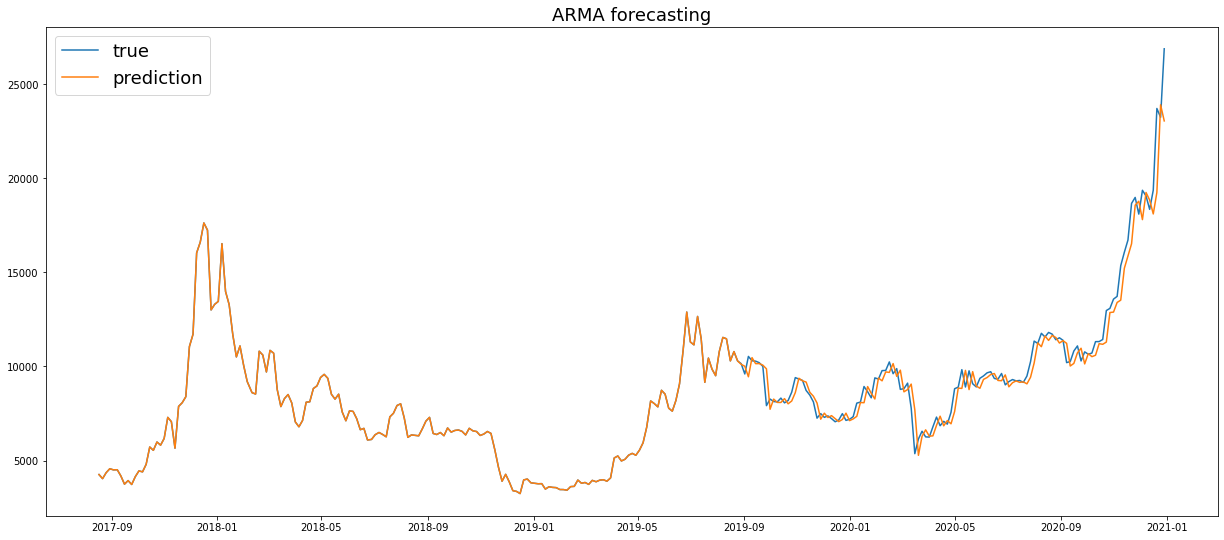

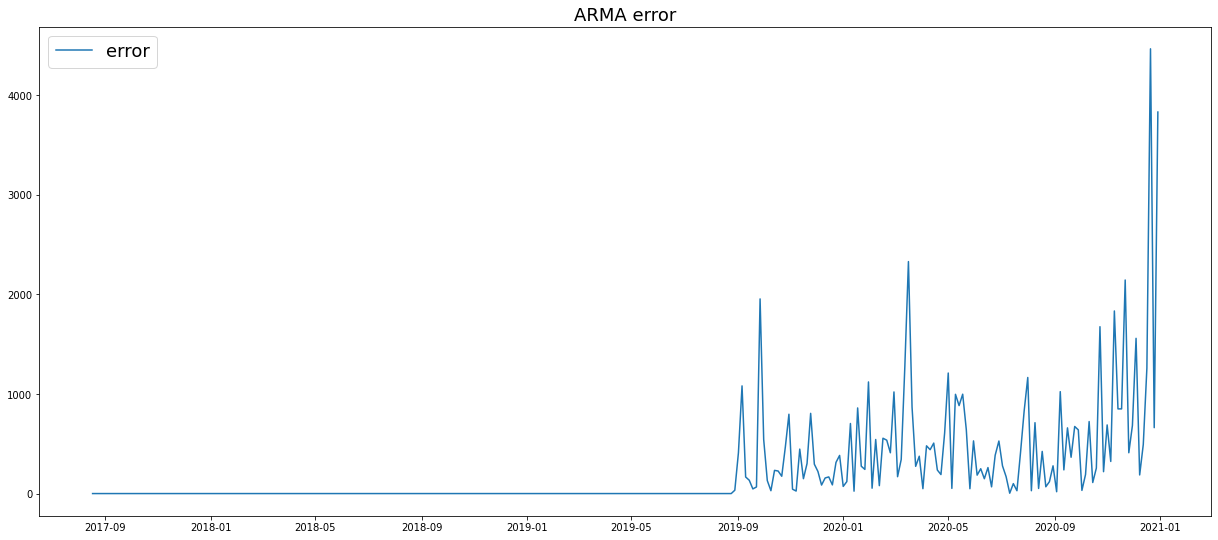

In [4]:
train, test = train_test_split(df.open[::100], test_size=0.4, shuffle=False)

size = len(test)
test = iter(test)

train = train.to_numpy()
predict = train.copy()
error = np.zeros_like(train)

for _ in range(size):
    model = ARIMA(train, order=(1, 0, 1)).fit()
    
    predict = np.append(predict, model.forecast())

    true = next(test)
    
    error = np.append(error, np.abs(true - model.forecast()))
    train = np.append(train, true)
        
print("RMSE: {0}".format(np.sqrt(mean_squared_error(train, predict))))

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], train, label="true")
plt.plot(df.start[::100], predict, label="prediction")
plt.legend(fontsize=18)
plt.title("ARMA forecasting", fontsize=18)
plt.show()

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], error, label="error")
plt.legend(fontsize=18)
plt.title("ARMA error", fontsize=18)
plt.show()

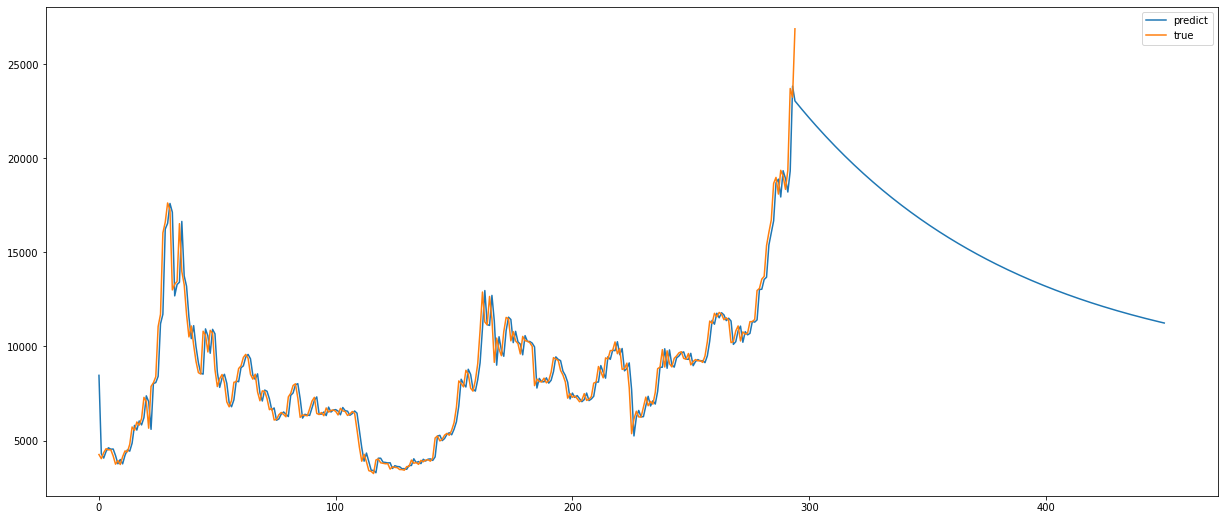

In [5]:
plt.plot(model.predict(0, 450), label='predict')
plt.plot(train, label="true")
plt.legend()

### ARIMA


RMSE: 533.5056201940982


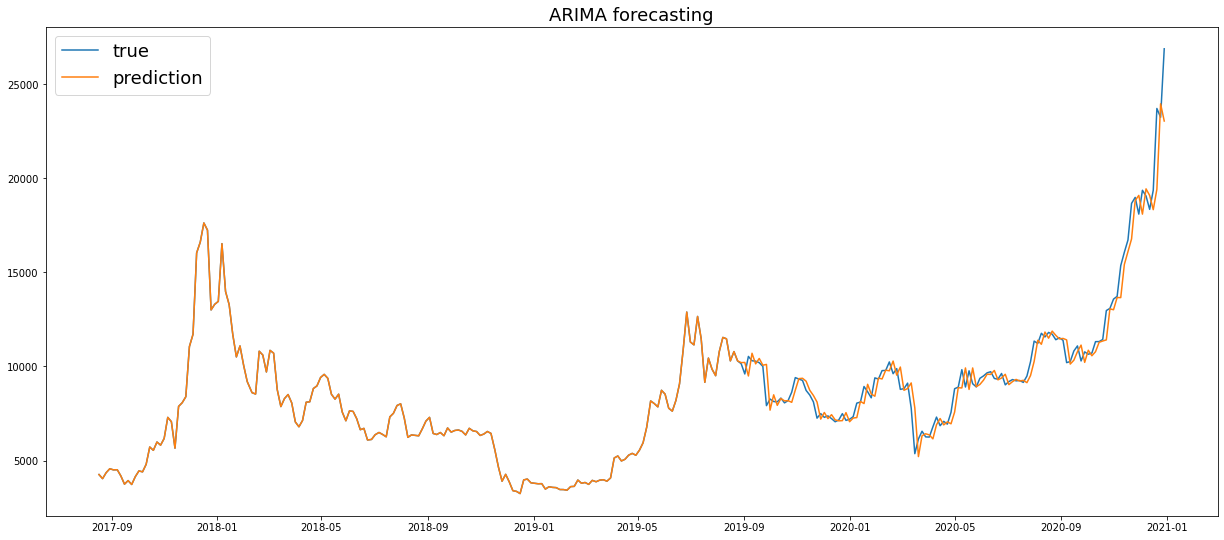

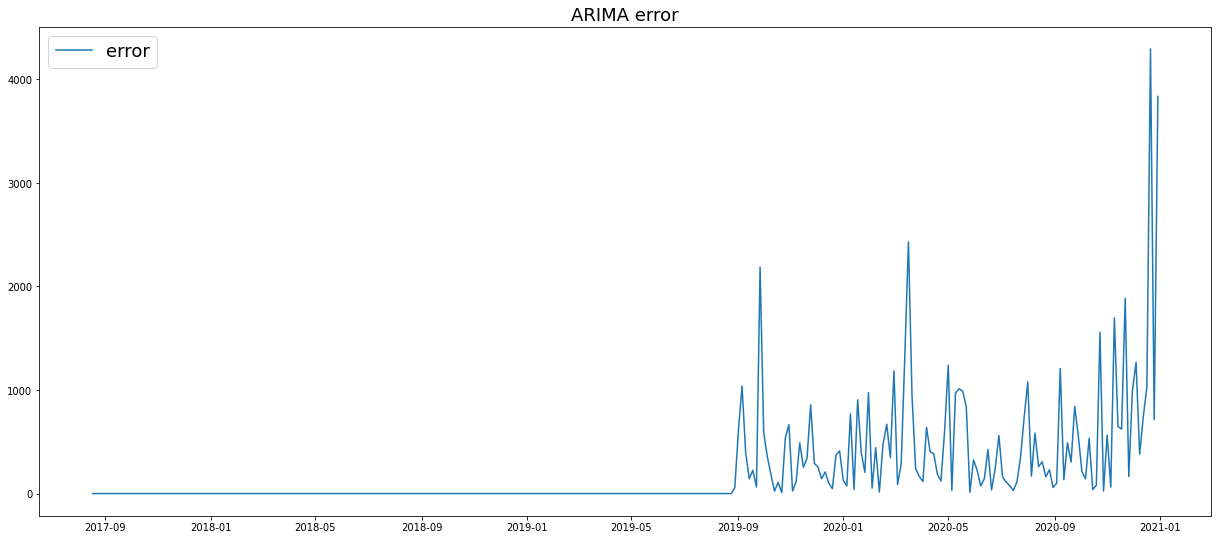

In [6]:
train, test = train_test_split(df.open[::100], test_size=0.4, shuffle=False)

size = len(test)
test = iter(test)

train = train.to_numpy()
predict = train.copy()
error = np.zeros_like(train)

for _ in range(size):
    model = ARIMA(train, order=(1, 1, 1)).fit()
    
    predict = np.append(predict, model.forecast())

    true = next(test)
    
    error = np.append(error, np.abs(true - model.forecast()))
    train = np.append(train, true)
        
print("RMSE: {0}".format(np.sqrt(mean_squared_error(train, predict))))

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], train, label="true")
plt.plot(df.start[::100], predict, label="prediction")
plt.legend(fontsize=18)
plt.title("ARIMA forecasting", fontsize=18)
plt.show()

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], error, label="error")
plt.legend(fontsize=18)
plt.title("ARIMA error", fontsize=18)
plt.show()

### SARIMA

RMSE: 533.5056201940982


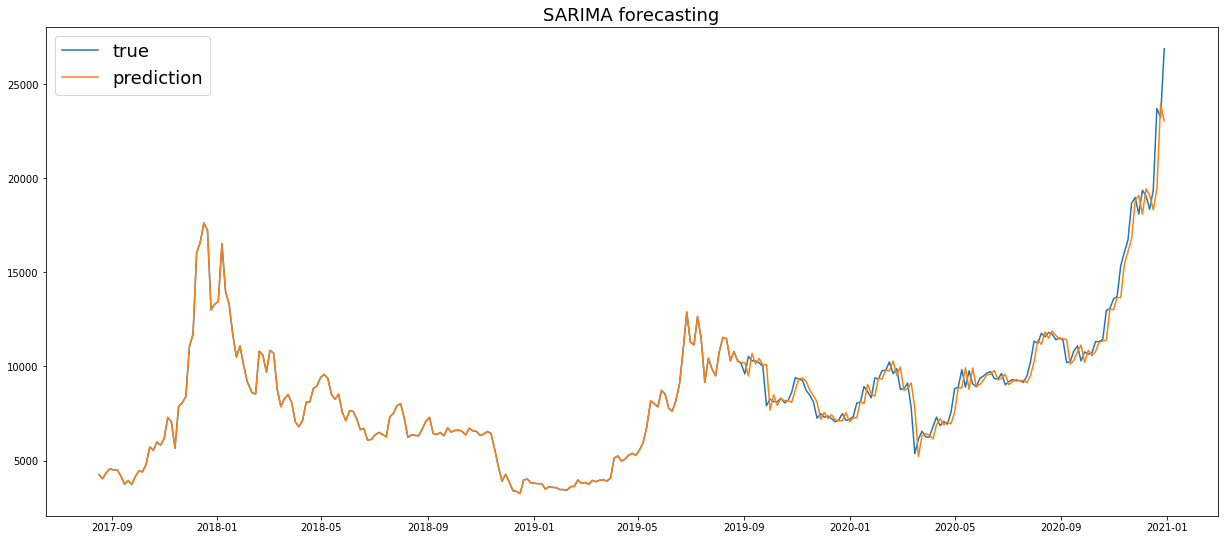

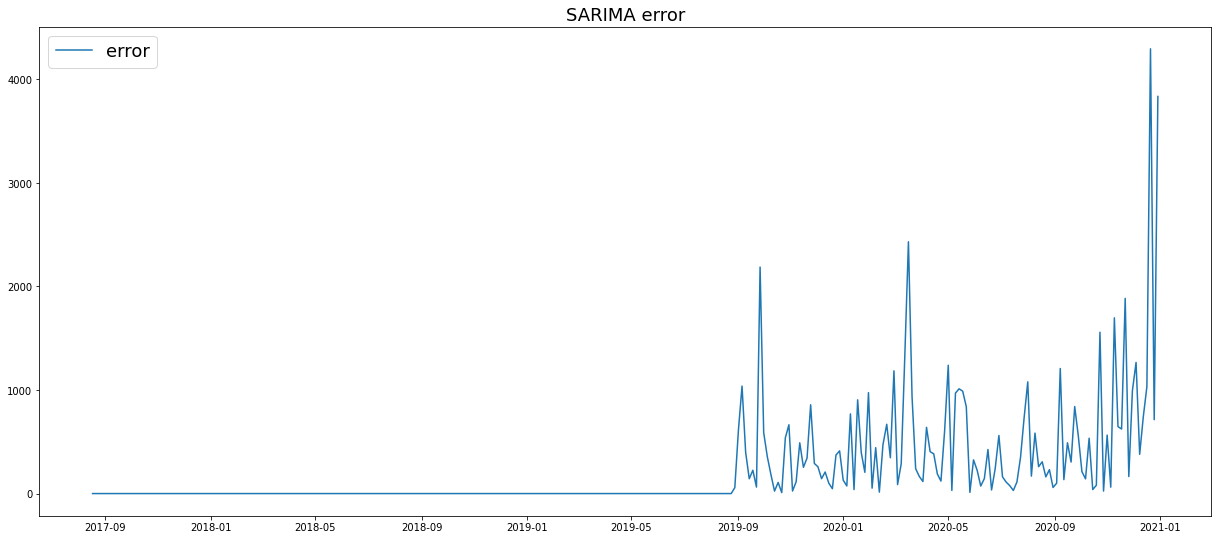

In [7]:
train, test = train_test_split(df.open[::100], test_size=0.4, shuffle=False)

size = len(test)
test = iter(test)

train = train.to_numpy()
predict = train.copy()
error = np.zeros_like(train)

for _ in range(size):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 2)).fit()
    
    predict = np.append(predict, model.forecast())

    true = next(test)
    
    error = np.append(error, np.abs(true - model.forecast()))
    train = np.append(train, true)
        
print("RMSE: {0}".format(np.sqrt(mean_squared_error(train, predict))))

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], train, label="true")
plt.plot(df.start[::100], predict, label="prediction")
plt.legend(fontsize=18)
plt.title("SARIMA forecasting", fontsize=18)
plt.show()

plt.rc("figure", figsize=(21, 9))
plt.plot(df.start[::100], error, label="error")
plt.legend(fontsize=18)
plt.title("SARIMA error", fontsize=18)
plt.show()